# Wikipedia Toxicity

''' Using NLP and machine learning, make a model to identify toxic comments from the Talk edit pages on Wikipedia.
 Help identify the words that make a comment toxic.'''


#Analysis to be done: Build a text classification model using NLP and machine learning that detects toxic comments.

In [1]:
# import packages
import pandas as pd
import re
import contractions
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np

# 1. Load the data using read_csv function from pandas package

In [2]:
# 2. Get the comments into a list, for easy text cleanup and manipulation - using DF
wiki_comments = pd.read_csv("train.csv")
wiki_comments.head()

,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0


In [3]:
wiki_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   object
 1   comment_text  5000 non-null   object
 2   toxic         5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [4]:
# Check for null values - no null found
wiki_comments.isnull().sum()

id              0
comment_text    0
toxic           0
dtype: int64

In [5]:
# drop 'id' column as it has no relevance to the model
wiki_comments.drop(['id'], axis =1, inplace=True)
wiki_comments.head()

,comment_text,toxic
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,New Categories \r\n\r\nI honestly think that w...,0


In [6]:
# Check for class balance - Toxic comments are less than 10%
wiki_comments['toxic'].value_counts(normalize=True)

0    0.9126
1    0.0874
Name: toxic, dtype: float64

<AxesSubplot:title={'center':'Value count of Toxic Comments'}>

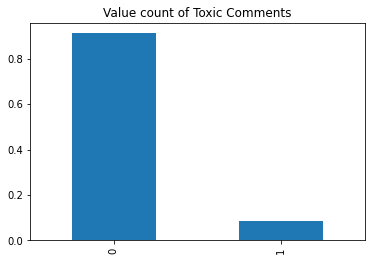

In [7]:
wiki_comments['toxic'].value_counts(normalize=True).plot(kind="bar", title="Value count of Toxic Comments")

# 3. Data Cleanup

In [8]:
wiki_comments.head()

,comment_text,toxic
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,New Categories \r\n\r\nI honestly think that w...,0


In [9]:
wiki_comments['comment_text'][1963]

'ass neck \r\n\r\nVirtual Graffiti: hmm.. seems close.....um not sure.....um..wait yes you have an ass on your neck.\r\n\r\nhahah; you are beyond a fool'

In [10]:
# re.findall(r"\d+.\d+.*", "jbejd wkdhk 10.1.23")
# re.sub(r"\d+.\d+.*", "", wiki_comments['comment_text'][12])
# re.findall(r"http:\S+", wiki_comments['comment_text'][16])
# re.sub(r"http:\S+", "", wiki_comments['comment_text'][16])
# re.findall(r"\W+", wiki_comments['comment_text'][17].lower())
# re.sub(r"\W+", " ", wiki_comments['comment_text'][17].lower())
# contractions.fix(wiki_comments['comment_text'][17])
#lemmatizer.lemmatize('ass')
#re.findall(r"\w{3,9}.\d{2}..\d{4}", wiki_comments['comment_text'][2].lower())
# re.findall(r"\w{3,9}.\d{2}..\d{4}|\d{4}|\d{1,2}.\w{3,9}.\d{4}|\d{1,2}.\w{3,9}", wiki_comments['comment_text'][44].lower())
#cleanup(wiki_comments['comment_text'][1963])

In [11]:
# Stopwords
nltk_stopwords = set(stopwords.words('english'))
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
all_stopwords = nltk_stopwords.union(sklearn_stopwords)
#print("Total num of stopwords : ", len(all_stopwords))

In [12]:
# Function to remove stopwords
def remove_stopwords(text, sw):
    text = [t for t in text.split() if t not in sw]
    if len(sw) > 100:
        return text
    return ' '.join(text)

In [13]:
# Define a function to perform data cleaning
def cleanup(comment):
    # 3.3. Normalize the casing
    # Removing dates
    cleaned_text = re.sub(r"\w{3,9}.\d{2}..\d{4}|\d{4}|\d{1,2}.\w{3,9}.\d{4}|\d{1,2}.\w{3,9}", "", comment.lower())
    
    # 3.1. Using regular expressions, remove IP addresses
    cleaned_text = re.sub(r"\d+.\d+.*", "", cleaned_text)
    
    # 3.2. Using regular expressions, remove URLs
    cleaned_text = re.sub(r"http:\S+", "", cleaned_text)
    cleaned_text = re.sub(r"\S+.com\S+", "", cleaned_text)
    
    # Remove contractions such as we'd
    cleaned_text = contractions.fix(cleaned_text)
    
    # 3.6 Remove punctuation and numbers
    cleaned_text = re.sub(r"[^a-z]", " ", cleaned_text)
    
    # 3.4. Tokenize
    # 3.5. Remove stop words
    cleaned_comment = ''
    comment_afterstopword_removal = remove_stopwords(cleaned_text, all_stopwords)
    
    # Removing words of length 2 or less
    # Lemmatization
    for t in comment_afterstopword_removal:
        lem = lemmatizer.lemmatize(t)
        if(len(lem) > 2):
            cleaned_comment = cleaned_comment + lem + ' '
        
    return cleaned_comment
    

In [14]:
wiki_comments['cleaned_comments'] = wiki_comments['comment_text'].apply(lambda x: cleanup(x))

In [15]:
wiki_comments['cleaned_comments'].head()

0    barnstar defender wiki barnstar like edit kaya...
1    unbalanced said mathsci said far extreme unple...
2    marya dzmitruk born minsk belarus mother olga ...
3                              talkback dear celestia 
4    new category honestly think need add category ...
Name: cleaned_comments, dtype: object

# 4. Using a counter, find the top terms in the data. 

In [16]:
# Write a code to collect all the words from all tweets into a single list
def get_allWords(colname):
    all_words = []
    for t in wiki_comments[colname]:
        all_words.extend(t.split())
    print("Number of words: ", len(all_words))
    return all_words

In [17]:
def Plot_FreqDist(all_words, top=25):
    freq_dist = nltk.FreqDist(all_words)

    plt.figure(figsize=(12,5))
    plt.title('Top 25 most common words')
    plt.xticks(fontsize=15)

    freq_dist.plot(top, cumulative=False)
    plt.show()

# Frequency Distribution
def freqDist_plot(colname, top=25):
    all_words = get_allWords(colname)
    Plot_FreqDist(all_words, top)
    


Number of words:  140096


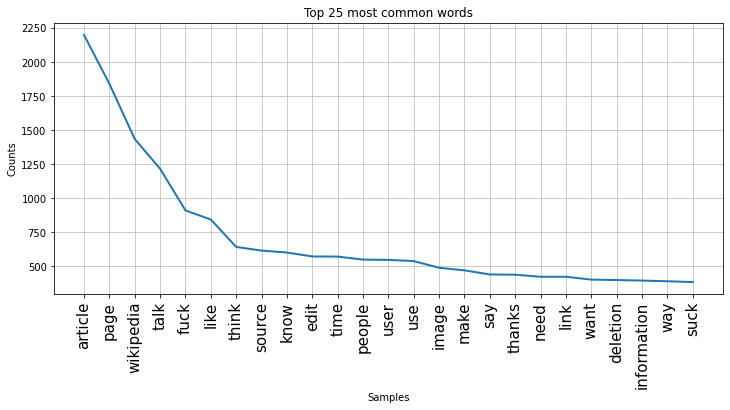

In [18]:
# Word count before contextual stopwords removal - 141290
freqDist_plot('cleaned_comments')

In [19]:
# 4.1. Can any of these be considered contextual stop words? - dropping contextual stopwords
# Words like “Wikipedia”, “page”, “edit” are examples of contextual stop words
Contextual_Stopwords = {"wikipedia", "page", "edit", "article", "wiki", "wikiproject", "edits"}
colname = 'stopwords_cleaned_comments'
#print(remove_stopwords(wiki_comments['cleaned_comments'][50], contextual_stopwords))
wiki_comments[colname] = wiki_comments['cleaned_comments'].apply(lambda x: remove_stopwords(x, Contextual_Stopwords))

In [20]:
wiki_comments.head()

,comment_text,toxic,cleaned_comments,stopwords_cleaned_comments
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0,barnstar defender wiki barnstar like edit kaya...,barnstar defender barnstar like kayastha let f...
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0,unbalanced said mathsci said far extreme unple...,unbalanced said mathsci said far extreme unple...
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0,marya dzmitruk born minsk belarus mother olga ...,marya dzmitruk born minsk belarus mother olga ...
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0,talkback dear celestia,talkback dear celestia
4,New Categories \r\n\r\nI honestly think that w...,0,new category honestly think need add category ...,new category honestly think need add category ...


Number of words:  133475


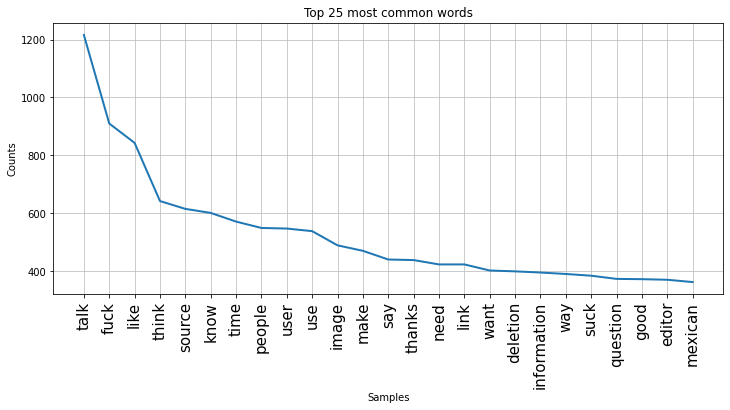

In [21]:
# Plot after contextual stopword removal
freqDist_plot(colname)

# 5. Separate data into train and test sets

In [22]:
from sklearn.model_selection import train_test_split

X = wiki_comments['stopwords_cleaned_comments']
y = wiki_comments['toxic']

# 5.2. Use a 70-30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

In [23]:
print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

X Train shape:  (3500,)
X Test shape:  (1500,)
0    0.9126
1    0.0874
Name: toxic, dtype: float64
0    0.912571
1    0.087429
Name: toxic, dtype: float64
0    0.912667
1    0.087333
Name: toxic, dtype: float64


# 6. Use TF-IDF values for the terms as feature to get into a vector space model

In [24]:
# 6.1. Import TF-IDF vectorizer from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
# 6.2. Instantiate with a maximum of 4000 terms in your vocabulary
TFIDF = TfidfVectorizer(max_features=4000)

In [26]:
# 6.3. Fit and apply on the train set
tfidf_x_train = TFIDF.fit_transform(X_train)
print(tfidf_x_train.shape)
TFIDF.get_feature_names_out()

(3500, 4000)


array(['abc', 'abe', 'ability', ..., 'zeta', 'zheng', 'zone'],
      dtype=object)

In [27]:
# 6.4. Apply on the test set
tfidf_x_test = TFIDF.transform(X_test)
print(tfidf_x_test.shape)

(1500, 4000)


# 7. Model building: Support Vector Machine

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

In [29]:
# 7.1. Instantiate SVC from sklearn with a linear kernel
SVC_1 = SVC(kernel='linear')

In [30]:
# 7.2. Fit on the train data
SVC_1.fit(tfidf_x_train, y_train)

SVC(kernel='linear')

In [31]:
# 7.3. Make predictions for the train and the test set
svc_pred = SVC_1.predict(tfidf_x_test)

# 8. Model evaluation: Accuracy, recall, and f1_score

In [32]:
# 8.1. Report the accuracy on the train set
SVC_1.score(tfidf_x_train, y_train)

0.9711428571428572

In [33]:
# Model has good accuracy
SVC_1.score(tfidf_x_test, y_test)

0.9433333333333334

In [34]:
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [35]:
# Recall score is low - 0.39
recall_score(y_test, svc_pred)

0.3893129770992366

In [36]:
# Recall score on balanced dataset is better than normal recall score  - 69%
balanced_accuracy_score(y_test, svc_pred)

0.6928303380748192

In [37]:
# 8.2. Report the recall on the train set: decent, high, low?
# Recall on the test set looks low - 0.39
# Get the f1_score on the train set
# f1_score is medium - 0.54
# The model predicts 0.91 accurately
precision_recall_fscore_support(y_test, svc_pred)

(array([0.94459834, 0.91071429]),
 array([0.9963477 , 0.38931298]),
 array([0.96978315, 0.54545455]),
 array([1369,  131]))

In [38]:
# Using StratifiedKFold for class imbalance
# Model train accuracy is 97.03 while test accuracy is 94.46 which looks good
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(SVC_1, tfidf_x_train, y_train, cv=kfold, scoring='accuracy', return_train_score=True)
print(np.round((results['train_score'].mean())*100, 2), np.round((results['train_score'].std())*100, 2)) 
print(np.round((results['test_score'].mean())*100, 2), np.round((results['test_score'].std())*100, 2)) 

97.03 0.12
94.46 0.68


In [39]:
# Defining a method to check a model's accuracy
def test_accuracy(SVC_model, x_train = tfidf_x_train, x_test=tfidf_x_test):
    SVC_model.fit(x_train, y_train)
    svc_pred = SVC_model.predict(x_test)
    results = cross_validate(SVC_model, x_train, y_train, cv=kfold, scoring='accuracy', return_train_score=True)
    print(np.round((results['train_score'].mean())*100, 2), np.round((results['train_score'].std())*100, 2)) 
    print(np.round((results['test_score'].mean())*100, 2), np.round((results['test_score'].std())*100, 2)) 
    print(precision_recall_fscore_support(y_test, svc_pred))

# 9. Adjust  the class imbalance, as the model seems to focus on the 0s

# 10. Train again with the adjustment and evaluate

In [40]:
# 9.1. Adjust the appropriate parameter in the SVC module
# adding balanced class weight - model looks overfitted

# 10.2. Evaluate the predictions on the validation set: 
# accuracy - test accuracy has decreased and model looks overfitted
# recall - There is an improvement in recall score but not as high as desired - 0.56
# f1_score - 0.57 is higher than the previous model but as high as desired

SVC_2 = SVC(kernel='linear', class_weight='balanced')
test_accuracy(SVC_2)

98.68 0.22
93.83 0.65
(array([0.95778748, 0.57936508]), array([0.96128561, 0.55725191]), array([0.95953336, 0.56809339]), array([1369,  131]))


# 11. Hyperparameter tuning

In [41]:
# 11.1. Import GridSearch and StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [42]:
# 11.2. Provide the parameter grid to choose for ‘C’
C_values = np.arange(0.00001, 1, 0.05) # 20 values
C_values

array([1.0000e-05, 5.0010e-02, 1.0001e-01, 1.5001e-01, 2.0001e-01,
       2.5001e-01, 3.0001e-01, 3.5001e-01, 4.0001e-01, 4.5001e-01,
       5.0001e-01, 5.5001e-01, 6.0001e-01, 6.5001e-01, 7.0001e-01,
       7.5001e-01, 8.0001e-01, 8.5001e-01, 9.0001e-01, 9.5001e-01])

In [43]:
# 11.3. Use a balanced class weight while instantiating the Support Vector Classifier
grid = GridSearchCV(estimator=SVC_2, param_grid={'C': C_values}, cv=kfold, scoring='accuracy', \
                    return_train_score=True, verbose=2, n_jobs=-1)
grid_results = grid.fit(tfidf_x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [44]:
grid_results.best_params_, grid_results.best_score_, grid_results.best_index_

({'C': 0.10001}, 0.9454285714285714, 2)

In [45]:
grid_results.cv_results_['mean_train_score'][grid_results.best_index_]*100

97.65

In [46]:
grid_results.cv_results_['mean_test_score'][grid_results.best_index_]*100

94.54285714285714

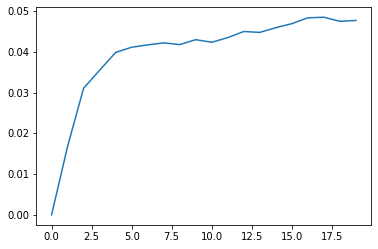

In [47]:
plt.plot(grid_results.cv_results_['mean_train_score'] - grid_results.cv_results_['mean_test_score'])

# 12. Find the parameters with the best recall in cross validation

In [48]:
# 12.1. Choose ‘recall’ as the metric for scoring
grid = GridSearchCV(estimator=SVC_2, param_grid={'C': C_values}, cv=kfold, scoring='recall', \
                    return_train_score=True, verbose=2, n_jobs=-1)
grid_results = grid.fit(tfidf_x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


# 13. What are the best parameters?

In [49]:
grid_results.best_params_, grid_results.best_score_, grid_results.best_index_

({'C': 0.35001000000000004}, 0.6042834479111582, 7)

In [50]:
# C = 0.1 is the best parameter for accuracy
# C = 0.35 is the best parameter for recall

# 14. Predict and evaluate using the best estimator

In [51]:
# 14.1. Use best estimator from the accuracy grid search to make predictions on the test set
#  The difference in accuracy between train n test and SD reduces !
SVC_3 = SVC(kernel='linear', class_weight='balanced', C= 0.1)
test_accuracy(SVC_3)

97.65 0.14
94.54 0.58
(array([0.95776664, 0.69902913]), array([0.97735573, 0.54961832]), array([0.96746204, 0.61538462]), array([1369,  131]))


In [52]:
# 14.1. Use best estimator from the recall grid search to make predictions on the test set
# 14.2. The recall on the test set for the toxic comments is 0.62
# 14.3. The f1_score is 0.57
# Accuracy of model = 
SVC_4 = SVC(kernel='linear', class_weight='balanced', C= 0.35)
test_accuracy(SVC_4)

97.85 0.42
93.63 0.35
(array([0.96288048, 0.52941176]), array([0.94740687, 0.61832061]), array([0.955081  , 0.57042254]), array([1369,  131]))


In [53]:
# using min df in TFIDF and checking accuracy
TFIDF_min = TfidfVectorizer(max_features=4000, min_df=5)
TFIDF_x_train_min = TFIDF_min.fit_transform(X_train)
TFIDF_x_test_min = TFIDF_min.transform(X_test)

In [54]:
# SVC using Min df - This model seems good as well but with no improvement in Recall score
SVC_5 = SVC(kernel='linear', class_weight='balanced', C= 0.35)
test_accuracy(SVC_5, TFIDF_x_train_min, TFIDF_x_test_min)

97.1 0.41
93.09 0.35
(array([0.96249062, 0.48502994]), array([0.93718042, 0.61832061]), array([0.94966691, 0.54362416]), array([1369,  131]))


# 15. What are the most prominent terms in the toxic comments?

In [55]:
# Using the SVC model used for best recall score
svc_test = SVC_4.predict(tfidf_x_test)

In [56]:
svc_test[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [57]:
d = {'Toxicity':svc_test, 'Comments':X_test}
df = pd.DataFrame(data=d)
df.head()

,Toxicity,Comments
3249,0,daimlerchrysler relationship closer gone point...
1133,0,linked dennis brown quite obviously meant humo...
1659,0,fair use rationale image pinhead profile jpg t...
1694,1,halo make halo like glitch high charity begin ...
4094,0,hipocrite doubt isolated incident evidence lon...


In [58]:
#wiki_comments['comment_text'][1536]

In [59]:
# 15.1. Separate the comments from the test set that the model identified as toxic
# Label 1 identifies as 'Toxic'
toxic = df.groupby('Toxicity').get_group(1)
print(toxic.shape)

(153, 2)


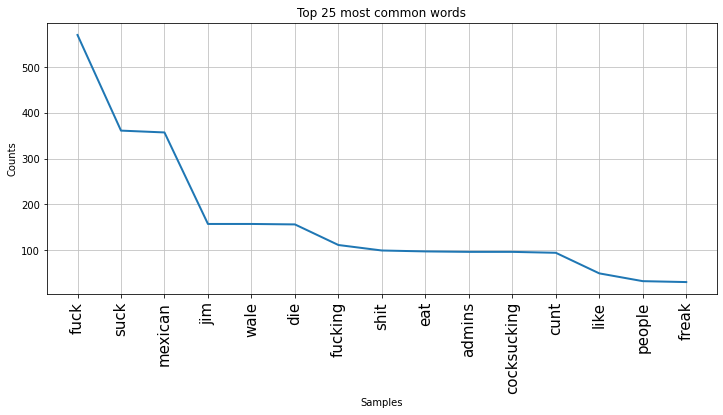

In [60]:
# 15.2. Make one large list of all the terms
all_words = []
for t in toxic['Comments']:
    all_words.extend(t.split())
  
# 15.3. Get the top 15 terms
Plot_FreqDist(all_words, 15)